# Implementación del K-means básico

En este notebook vamos a ver cómo implementar el algoritmo k-means. Dada la simplicidad del mismo, primero lo vamos a implementar nosotros mismos con Python. 

## Instalar bibliotecas

Vamos a hacer uso de distintas bibliotecas en este notebook. Si no las tienes instaladas en tu entorno de Python, lo puedes hacer ejecutando las siguientes instrucciones:

In [ ]:
!pip install numpy

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

Una vez instaladas, ya podemos importarlas:

In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

## Datos

Por simplicidad, vamos a usar un conjunto de datos clásico en machine learning: el dataset [Iris](https://archive.ics.uci.edu/ml/datasets/Iris), del repositorio UCI. Vamos a usar pandas dataframes para leer los datos (en formato csv):

In [3]:
X = pd.read_csv('iris.csv')

Veamos qué columnas tiene y su tipo de datos:

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Puesto que el objetivo del clustering es describir nuestros datos acorde a las características (en lugar de clasificar ejemplos), vamos a eliminar la columna `class` que no sería de interés para ello. Fíjate que en clustering no vamos (normalmente) a dividir el conjunto de datos en training y test, ya que solo tratamos de describir los datos. Sin embargo, dividir el conjunto podría ser buena idea para calcular algunas métricas que estudiaremos para analizar qué tan buena sea una agrupación. 

In [5]:
X = X.drop(columns=['class']) 

Mostremos las dimensiones (n) y el numero de ejemplos (m):

In [6]:
m = X.shape[0]
n = X.shape[1]
print(f"El numero de ejemplos y su dimension es {m}x{n}")

El numero de ejemplos y su dimension es 150x4


Veamos alguna estadísticas del conjunto de datos:

In [7]:
X.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Normalizar los datos

En el algoritmo del k-means es común el uso de la distancia Euclídea para calcular la similitud entre ejemplos. Por ello, es habitual normalizar el conjunto de datos, de modo que al calcular las distancias entre ejemplos no haya características que puedan estar contribuyendo más que otras en el resultado debido a su magnitud. Por ejemplo, `sepal_length` está en el rango [4.3-7.9], pero `petal_length` está en un rango más amplio [1,6.9]. 

Vamos a aplicar una normalización [0,1] (min-max):

In [8]:
X_norm = (X-X.min())/ (X.max()-X.min())

In [9]:
X_norm.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.440556,0.467458,0.458056
std,0.230018,0.181611,0.299203,0.317599
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


## Funciones de visualización

Para visualizar el progreso del algoritmo del k-means, vamos a usar una función que nos permite visualizar en 2 dimensiones un conjunto de datos (como un pandas dataframe), junto con unos centroides, e indicando los índices de las 2 características deben ser consideradas (`i` y `j`). También se puede indicar el 'cluster asignado' `c`, para pintar los agrupamientos de distintos colores.

In [10]:
def mostrar(X, c=None, centroids=None,i=0,j=0):

    # Creamos los mapas de colores a utilizar
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#FFFF00', '#0000FF'])

    # Creamos la figura
    plt.figure(figsize=(10,8))

    # Pintamos los puntos
    plt.scatter(X.iloc[:, i], X.iloc[:, j], c=c, cmap=cmap_bold, s=60)

    # Pintamos los centroides si los hay 
    if centroids is not None:
        plt.scatter(centroids.iloc[:,i], centroids.iloc[:,j], marker='*', c=range(centroids.shape[0]), s=500)

    # Mostramos la figura
    plt.show()

Vamos a pintar nuestro dataset, fijándonos en dos de sus características. Por ejemplo: `sepal_length` y `petal_width`:

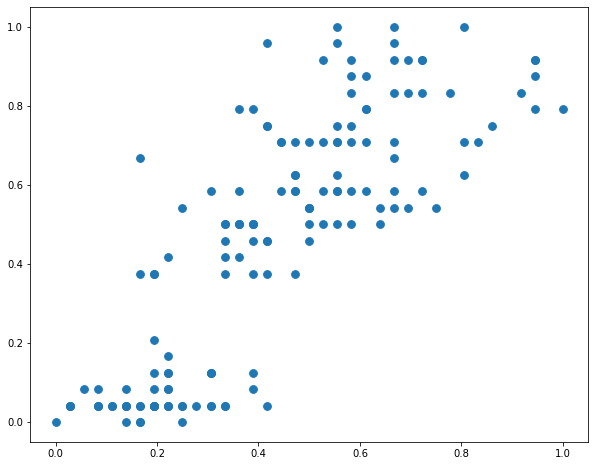

In [11]:
mostrar(X_norm,i=0,j=3)

## Implementación Manual del K-means

Recordemos la estructura del algoritmo de k-means:

```
Entrada: k (número de clústeres), m objetos
Procedimiento:
1. elegir aleatoriamente los centros de los clústeres
2. repetir mientras haya cambios:
	2.1  (re)asignar cada objeto al clúster con centro más cercano
	2.2. recalcular los centros como el punto medio de cada clúster
```

Definamos un valor de `k`:

In [12]:
k=3

Tenemos que empezar eligiendo aleatoriamente `k` centroides iniciales, que se deben elegir del conjunto de entrenamiento. Para que los resultados sean reproducibles, fijemos una semilla:

In [13]:
np.random.seed(12345)

`m` es el número de filas del dataset, si usamos numpy, podemos generar un vector desordenado de tamaño `m` que indique los índices de los elementos de `X_norm` que queremos seleccionar. 

`np.random.permutation(m)`

De dicho vector, seleccionamos solo `k` elementos:

In [14]:
indices = np.random.permutation(m)[:k]

Ahora podemos usar esos índices para seleccionar las instancias correspondientes:

In [15]:
centros = X_norm.iloc[indices, :]

Veamos dónde han caído estos centroides:

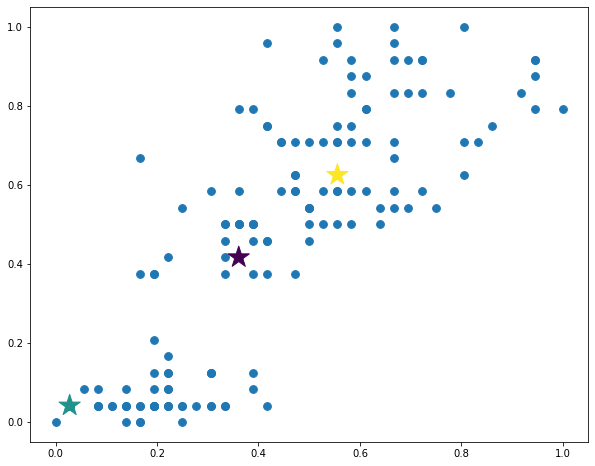

In [16]:
mostrar(X_norm,centroids=centros, i=0,j=3)

El siguiente paso es asignar cada elemento del conjunto de entrenamiento al centroide más cercano. Lo mejor será crear una función que nos calcule la distancia Euclídea a los centroides y determine cual es el más cercano:

In [17]:
def asigna(X, centroides):
    distancias = np.zeros((X.shape[0], centroides.shape[0]))
    for i in range(centroides.shape[0]):
        distancias[:, i] =  np.sqrt(np.sum(np.square(X - centroides.iloc[i]), axis=1))
    c = np.argmin(distancias, axis=1)
    return c

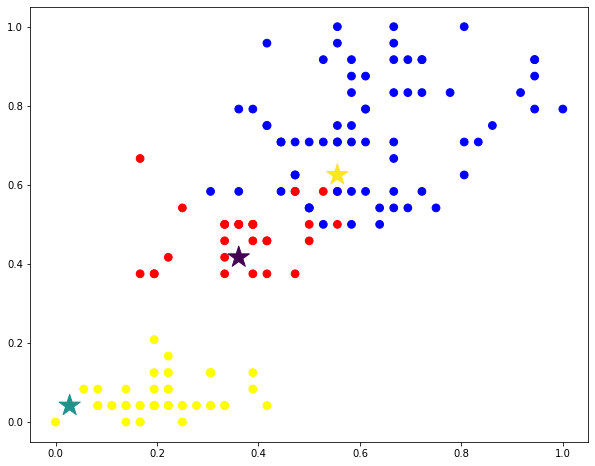

In [18]:
c = asigna(X_norm,centros)
mostrar(X_norm, c, centros, i=0,j=3)

Una vez tenemos inicializados los centroides, y tenemos una función que nos asigna los elementos a su centroide más cercano, nos falta encontrar una forma de recalcular la posición de los centroides en base a la asignación previa.

In [19]:
"""
función actualiza(X,c,k) modificada por Danel Arias para evitar
problemas con mi versión anterior con el append de Pandas
"""
def actualiza(X, c, k):
    new_centroids_list = []

    for i in range(k):
        cluster_mean = X.iloc[c == i].mean()
        new_centroids_list.append(cluster_mean)

    return pd.DataFrame(new_centroids_list, columns=X.columns) 

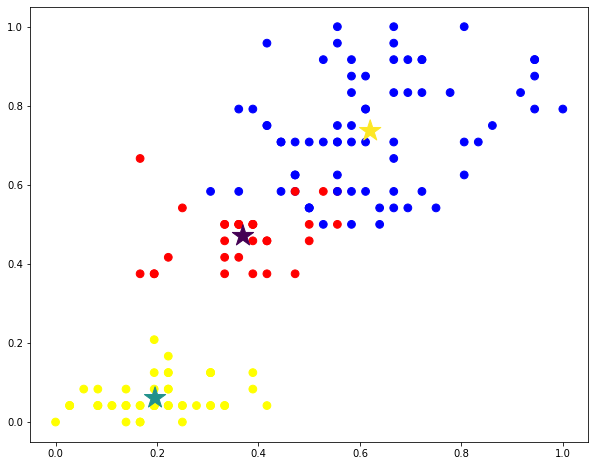

In [20]:
centros_new = actualiza(X_norm, c,k)
mostrar(X_norm, c, centros_new, i=0,j=3)

### Criterio de parada

Una vez tenemos las funciones para asignar y actualizar centroides, podríamos ponerlas en un bucle que repita dichas acciones hasta que se cumple un criterio de parada. Existen diversas formas para decidir cuándo el algoritmo del k-means debe parar. Un ejemplo es comprobar cuánto han cambiado los centroides, calculando la distancia entre ambos:

In [21]:
def cambio(centros, new_centros):
    temp_dist = 0
    for i in range(centros.shape[0]):
        temp_dist += np.sqrt(np.sum((new_centros.iloc[i] - centros.iloc[i])**2)) 
    return temp_dist

In [22]:
cambio(centros,centros_new)

0.46383491027343154

Deberemos definir un umbral de cambio que determine cuándo creemos que el algoritmo ha convergido.

In [23]:
def kmeans(X, k, umbral=0.001):
    
    # inicializamos los centroides:
    centros = X.iloc[np.random.permutation(m)[:k], :]

    # entramos en un bucle que parará 
    while True:
        # asigna centroides:
        c = asigna(X, centros)
        
        # actualiza los centroides:
        new_centros = actualiza(X,c,k)
        
        # hemos acabado?
        if cambio(centros, new_centros) < umbral:
            break
        else:
            centros=new_centros
    # devolvemos los últimos centroides y su asignación:        
    return new_centros, c

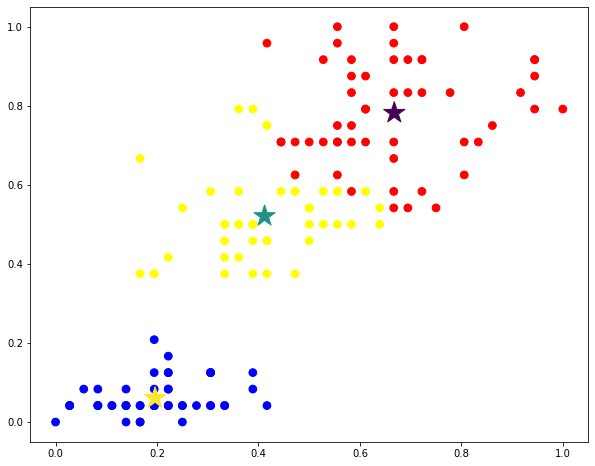

In [27]:
centros, c = kmeans(X_norm, k)
mostrar(X_norm, c, centros, i=0,j=3)

### Función objetivo y Mínimos locales

El criterio de parada, se ha basado simplemente en el cambio producido en los centroides de una iteración a otra. Es común definir una función de coste (función objetivo) que mida cuán bien los centroides están representando a los datos. Para el k-means, lo que tratamos de minimizar es la suma de las distancias entre cada ejemplo y el cluster al que pertenece. 

In [28]:
def coste(X, centroides, c):
    coste = 0
    for i in range(centroides.shape[0]):
        coste += np.sum(np.sum(np.square(X.loc[c == i, :] - centroides.iloc[i, :]), axis=1))

    return coste / X.shape[0]

En este caso nuestro criterio de parada será un número dado de iteraciones:

In [29]:
def kmeans(X, k, it=10):
    centros = X.iloc[np.random.permutation(m)[:k], :]
    J = np.zeros((it))
    for i in range(it):
        c = asigna(X, centros)
        centros = actualiza(X, c, k)
        J[i] = coste(X, centros, c)

    return centros, J, c

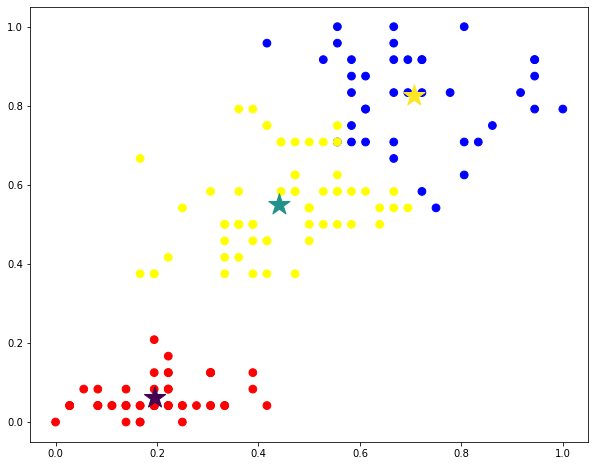

In [38]:
centroids, J, c = kmeans(X_norm, k)
mostrar(X_norm, c, centroids,i=0,j=3)

Podemos echarle un vistazo a cómo ha convergido el algoritmo:

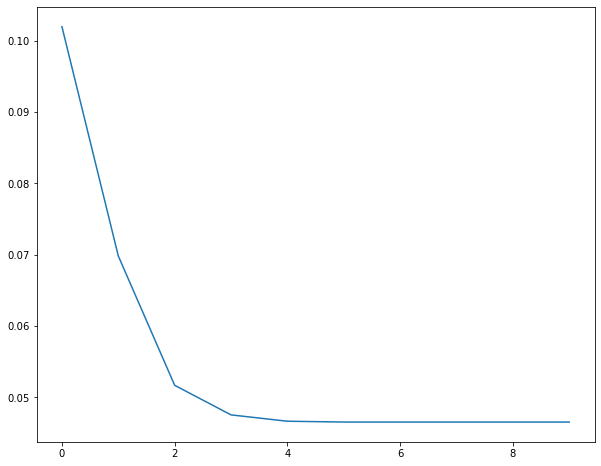

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(J)
plt.show()

Como el algoritmo comienza de manera aleatoria, es no determinista. Por lo tanto, si lo ejecutamos varias veces sobre el mismo conjunto de datos podemos obtener resultados distintos. Por ello, lo recomendable es ejecutarlo varias veces para no obtener una solución incorrecta. La función debería devolver los centroides y el vector de centroides de la solución con menor valor de la función objetivo.

In [40]:
def ejecutaKmeans(X,k, repeticiones=100):
    Jmin = np.inf
    Cmin = None
    for i in range(repeticiones):
        centroids, J, c = kmeans(X, k)
        if (J[-1] < Jmin):
            Jmin = J[-1]
            centroidsMin = centroids
            Cmin = c

    return centroidsMin, Jmin, Cmin 

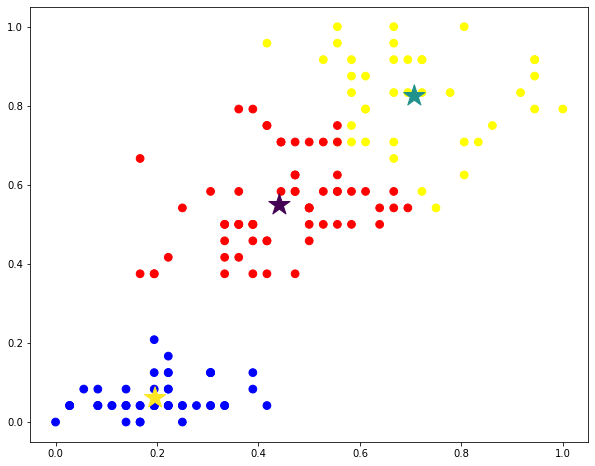

In [41]:
centros, J, c = ejecutaKmeans(X_norm,3)
mostrar(X_norm, c, centros, i=0,j=3)